In [2]:
# At first lets import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

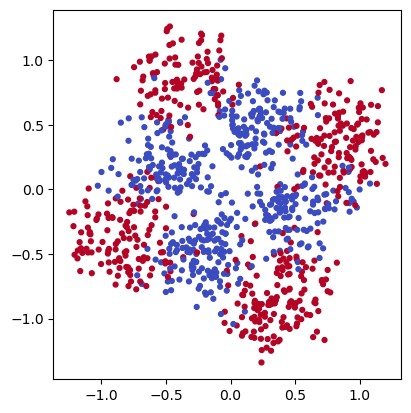

In [3]:
# Now lets create one synthetic dataset for classification task

# I have searched form the internet one interesting dataset called "Noisy flower"

def make_flower(n_samples=1000, petals=4, noise=0.1, random_state=42):
    np.random.seed(random_state)

    # Random radius (distance from the center)
    r = np.random.uniform(0.5, 1.0, n_samples)

    # Angle around the circle
    theta = np.random.uniform(0, 2 * np.pi, n_samples)

    # Apply a sinusoidal "petal" pattern
    # Bigger amplitude => sharper petals
    k = petals
    r_mod = r + 0.3 * np.sin(k * theta)

    # Convert to x,y
    X = np.vstack([
        r_mod * np.cos(theta),
        r_mod * np.sin(theta)
    ]).T

    # Add Gaussian noise for extra complexity
    X += noise * np.random.randn(n_samples, 2)

    # Label by which side of the sinusoid pattern they fall on
    y = (np.sin(k * theta) > 0).astype(np.float32)

    return X.astype('float32'), y.astype('float32')

# Example usage
X, y = make_flower()

# One inportant thing that if we increase our noise up to 0.4 or 0.5 the classification task will become much more difficult.
# Because we will have some kind of chaortic distribution of data points.

plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=12)
plt.gca().set_aspect('equal', 'box')
plt.show()


In [4]:
# At first lets split our dataset into train and test parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Now lets convert our data into torch tensors
# As we don't have too many data points we won't use DataLoader for batching
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)


In [5]:
# As our data is ready now we can create one class fro our neural network
# I will try to make structure to be free to change number of hidden layers and their sizes

class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=[16], output_size=1, activation=nn.ReLU):
        super(SimpleNN, self).__init__()
        layers = []
        in_size = input_size
        for h_size in hidden_size:
            layers.append(nn.Linear(in_size, h_size))
            layers.append(activation())
            in_size = h_size
        layers.append(nn.Linear(in_size, output_size))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    

In [6]:
# Also I have created decision boundary plotting function to visualize how our model is learning

def plot_decision_boundary(model, X, y, title='Decision Boundary', figsize=(15,8), levels=80):
    """
    Beautiful decision boundary plot for a 2D classification model.
    
    Parameters:
    - model : trained PyTorch model
    - X : torch.Tensor of shape (n_samples, 2)
    - y : torch.Tensor of shape (n_samples,)
    - title : plot title
    - figsize : tuple for figure size
    - levels : number of contour levels (higher -> smoother boundary)
    """
    # Create mesh grid
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # Flatten grid and convert to tensor
    grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
    grid_t = torch.from_numpy(grid)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        probs = model(grid_t).numpy().reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=figsize)
    # Smooth background with filled contour
    contour = plt.contourf(xx, yy, probs, levels=levels, cmap='coolwarm', alpha=0.4)
    # Overlay class points
    scatter = plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=40, edgecolor='k', linewidth=0.8)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.colorbar(contour, label='Predicted probability', shrink=0.8)
    plt.show()


In [7]:
# Also we can need one function that will train and eval our model (We will keep Adam as optimizer)
def train_and_evaluate(hiddeln_layers=[16, 16], learning_rate=0.01, n_epochs=1000, activation=nn.ReLU, loss_fn=nn.BCELoss):
    model = SimpleNN(hidden_size=hiddeln_layers, activation=activation)
    criterion = loss_fn()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Keep track of losses 
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                train_outputs = model(X_train_tensor)
                train_loss = criterion(train_outputs, y_train_tensor)
                train_losses.append(train_loss.item())
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor)
                test_losses.append(test_loss.item())

            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    # Plot losses
    plt.figure(figsize=(10,5))
    plt.plot(range(10, n_epochs+1, 10), train_losses, label='Train Loss')
    plt.plot(range(10, n_epochs+1, 10), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.show()

    # Plot decision boundary
    plot_decision_boundary(model, X, y, title=f'Decision Boundary with hidden layers: {hiddeln_layers}')

    # Evaluate accuracy
    model.eval()
    with torch.no_grad():
        predicted = (model(X_test_tensor) >= 0.5).float()
        accuracy = (predicted.eq(y_test_tensor).sum().item()) / y_test_tensor.size(0)
        print(f'Accuracy of model1 on test set: {accuracy * 100:.2f}%')

    return model



Epoch [10/200], Train Loss: 0.6713, Test Loss: 0.6725
Epoch [20/200], Train Loss: 0.6451, Test Loss: 0.6513
Epoch [30/200], Train Loss: 0.6138, Test Loss: 0.6277
Epoch [40/200], Train Loss: 0.5767, Test Loss: 0.6002
Epoch [50/200], Train Loss: 0.5323, Test Loss: 0.5614
Epoch [60/200], Train Loss: 0.4849, Test Loss: 0.5130
Epoch [70/200], Train Loss: 0.4450, Test Loss: 0.4731
Epoch [80/200], Train Loss: 0.4120, Test Loss: 0.4419
Epoch [90/200], Train Loss: 0.3855, Test Loss: 0.4185
Epoch [100/200], Train Loss: 0.3665, Test Loss: 0.4015
Epoch [110/200], Train Loss: 0.3528, Test Loss: 0.3899
Epoch [120/200], Train Loss: 0.3430, Test Loss: 0.3824
Epoch [130/200], Train Loss: 0.3360, Test Loss: 0.3784
Epoch [140/200], Train Loss: 0.3310, Test Loss: 0.3762
Epoch [150/200], Train Loss: 0.3275, Test Loss: 0.3754
Epoch [160/200], Train Loss: 0.3250, Test Loss: 0.3753
Epoch [170/200], Train Loss: 0.3233, Test Loss: 0.3754
Epoch [180/200], Train Loss: 0.3220, Test Loss: 0.3754
Epoch [190/200], Tr

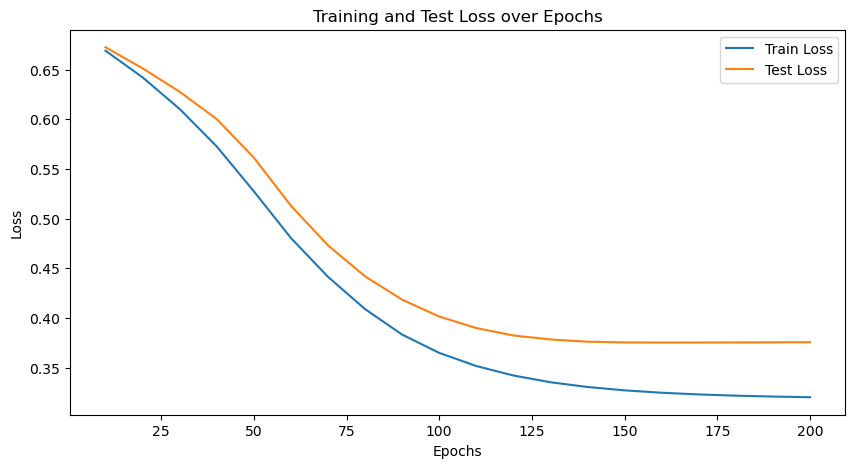

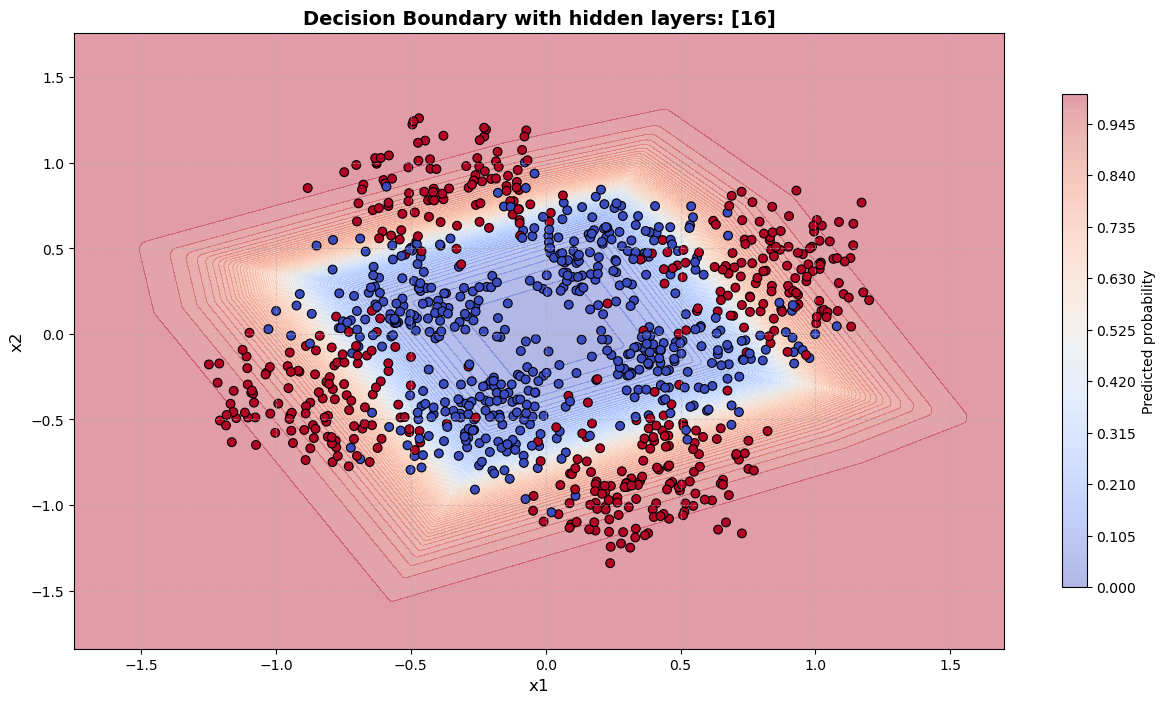

Accuracy of model1 on test set: 84.00%


In [8]:
# As we have our model's class we can start training and investigating some hyperparameters

# First model will be the simplest one with one hidden layer
model1 = train_and_evaluate(hiddeln_layers=[16], learning_rate=0.01, n_epochs=200)

Epoch [10/500], Train Loss: 0.6104, Test Loss: 0.6137
Epoch [20/500], Train Loss: 0.4554, Test Loss: 0.4940
Epoch [30/500], Train Loss: 0.3469, Test Loss: 0.4262
Epoch [40/500], Train Loss: 0.3317, Test Loss: 0.4077
Epoch [50/500], Train Loss: 0.3235, Test Loss: 0.3967
Epoch [60/500], Train Loss: 0.3147, Test Loss: 0.3830
Epoch [70/500], Train Loss: 0.3105, Test Loss: 0.3768
Epoch [80/500], Train Loss: 0.3076, Test Loss: 0.3710
Epoch [90/500], Train Loss: 0.3051, Test Loss: 0.3718
Epoch [100/500], Train Loss: 0.3027, Test Loss: 0.3669
Epoch [110/500], Train Loss: 0.3000, Test Loss: 0.3664
Epoch [120/500], Train Loss: 0.2973, Test Loss: 0.3609
Epoch [130/500], Train Loss: 0.2946, Test Loss: 0.3599
Epoch [140/500], Train Loss: 0.2920, Test Loss: 0.3574
Epoch [150/500], Train Loss: 0.2899, Test Loss: 0.3578
Epoch [160/500], Train Loss: 0.2881, Test Loss: 0.3571
Epoch [170/500], Train Loss: 0.2857, Test Loss: 0.3557
Epoch [180/500], Train Loss: 0.2824, Test Loss: 0.3503
Epoch [190/500], Tr

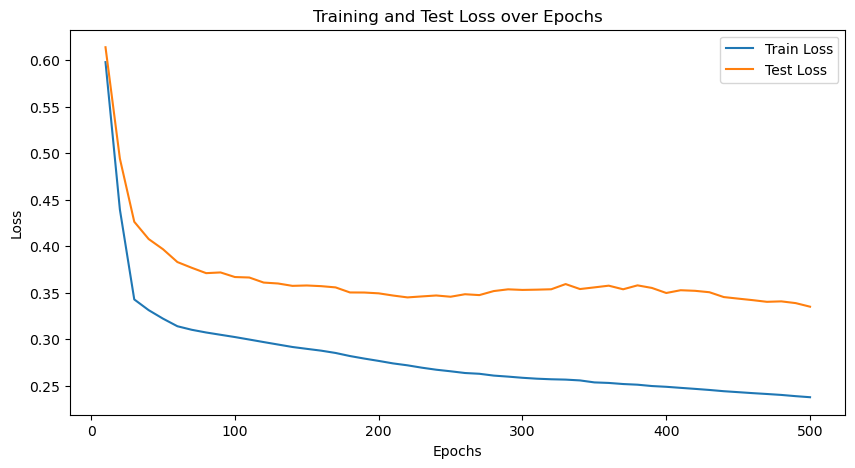

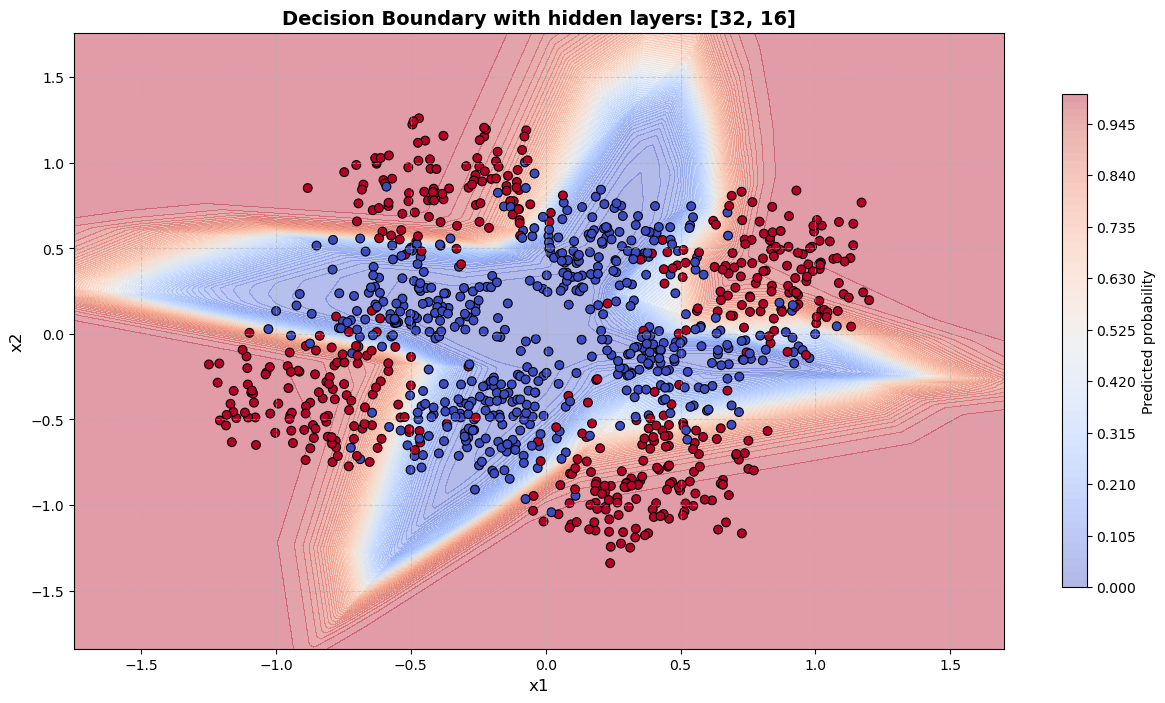

Accuracy of model1 on test set: 87.00%


In [9]:
# Now we can create our model, define loss function and optimizer
model2 = train_and_evaluate(hiddeln_layers=[32, 16], learning_rate=0.01, n_epochs=500)


Epoch [10/1000], Train Loss: 0.5663, Test Loss: 0.5637
Epoch [20/1000], Train Loss: 0.3486, Test Loss: 0.4396
Epoch [30/1000], Train Loss: 0.3122, Test Loss: 0.3692
Epoch [40/1000], Train Loss: 0.2968, Test Loss: 0.3478
Epoch [50/1000], Train Loss: 0.2836, Test Loss: 0.3318
Epoch [60/1000], Train Loss: 0.2696, Test Loss: 0.3122
Epoch [70/1000], Train Loss: 0.2549, Test Loss: 0.2977
Epoch [80/1000], Train Loss: 0.2453, Test Loss: 0.2974
Epoch [90/1000], Train Loss: 0.2375, Test Loss: 0.3012
Epoch [100/1000], Train Loss: 0.2354, Test Loss: 0.2990
Epoch [110/1000], Train Loss: 0.2333, Test Loss: 0.3102
Epoch [120/1000], Train Loss: 0.2328, Test Loss: 0.3053
Epoch [130/1000], Train Loss: 0.2313, Test Loss: 0.3177
Epoch [140/1000], Train Loss: 0.2292, Test Loss: 0.3090
Epoch [150/1000], Train Loss: 0.2280, Test Loss: 0.3157
Epoch [160/1000], Train Loss: 0.2286, Test Loss: 0.3224
Epoch [170/1000], Train Loss: 0.2277, Test Loss: 0.3161
Epoch [180/1000], Train Loss: 0.2267, Test Loss: 0.3300
E

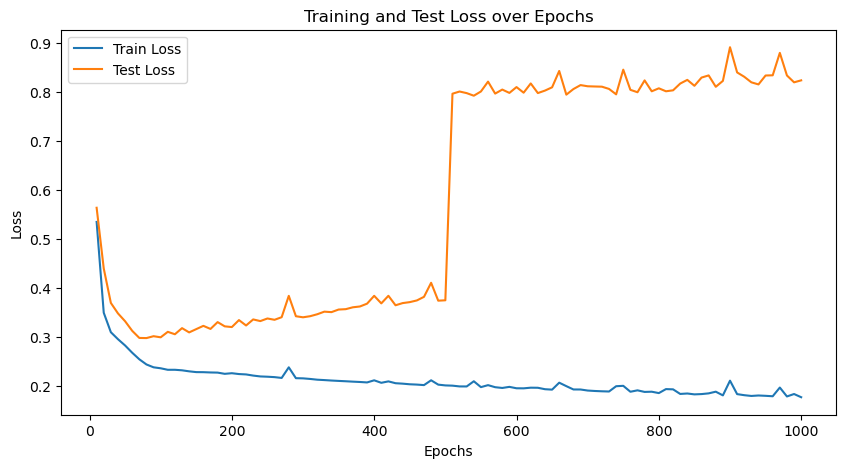

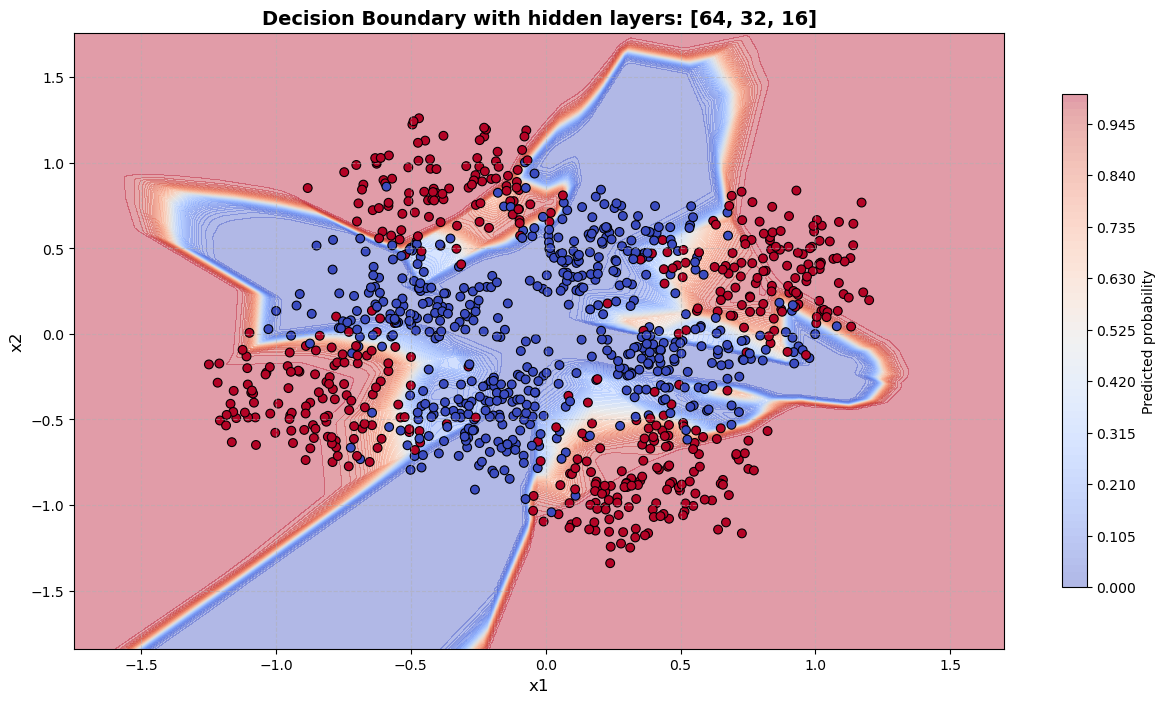

Accuracy of model1 on test set: 87.50%


In [10]:
# Now Lets create even more complex model with three hidden layers
model3 = train_and_evaluate(hiddeln_layers=[64, 32, 16], learning_rate=0.01, n_epochs=1000)


Epoch [10/1000], Train Loss: 0.4227, Test Loss: 0.4732
Epoch [20/1000], Train Loss: 0.3485, Test Loss: 0.4249
Epoch [30/1000], Train Loss: 0.3156, Test Loss: 0.3824
Epoch [40/1000], Train Loss: 0.3011, Test Loss: 0.3644
Epoch [50/1000], Train Loss: 0.2898, Test Loss: 0.3400
Epoch [60/1000], Train Loss: 0.2717, Test Loss: 0.3185
Epoch [70/1000], Train Loss: 0.2542, Test Loss: 0.3109
Epoch [80/1000], Train Loss: 0.2419, Test Loss: 0.3132
Epoch [90/1000], Train Loss: 0.2403, Test Loss: 0.3122
Epoch [100/1000], Train Loss: 0.2337, Test Loss: 0.3161
Epoch [110/1000], Train Loss: 0.2324, Test Loss: 0.3268
Epoch [120/1000], Train Loss: 0.2308, Test Loss: 0.3170
Epoch [130/1000], Train Loss: 0.2348, Test Loss: 0.3381
Epoch [140/1000], Train Loss: 0.2299, Test Loss: 0.3278
Epoch [150/1000], Train Loss: 0.2274, Test Loss: 0.3282
Epoch [160/1000], Train Loss: 0.2261, Test Loss: 0.3220
Epoch [170/1000], Train Loss: 0.2247, Test Loss: 0.3244
Epoch [180/1000], Train Loss: 0.2252, Test Loss: 0.3673
E

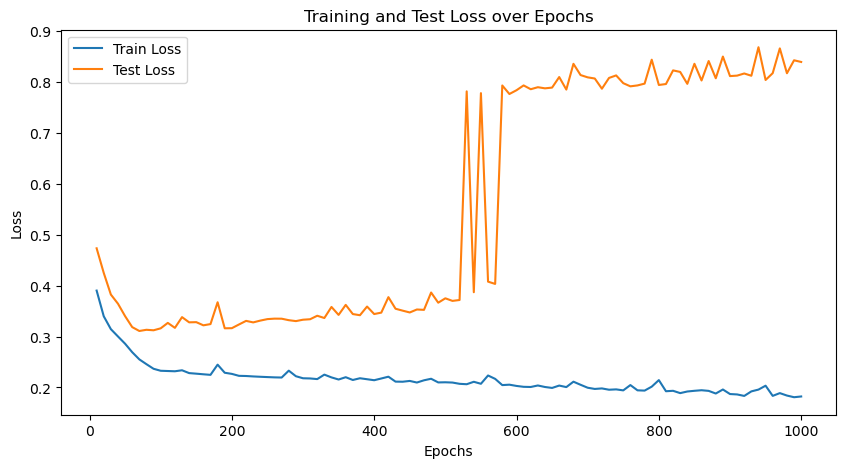

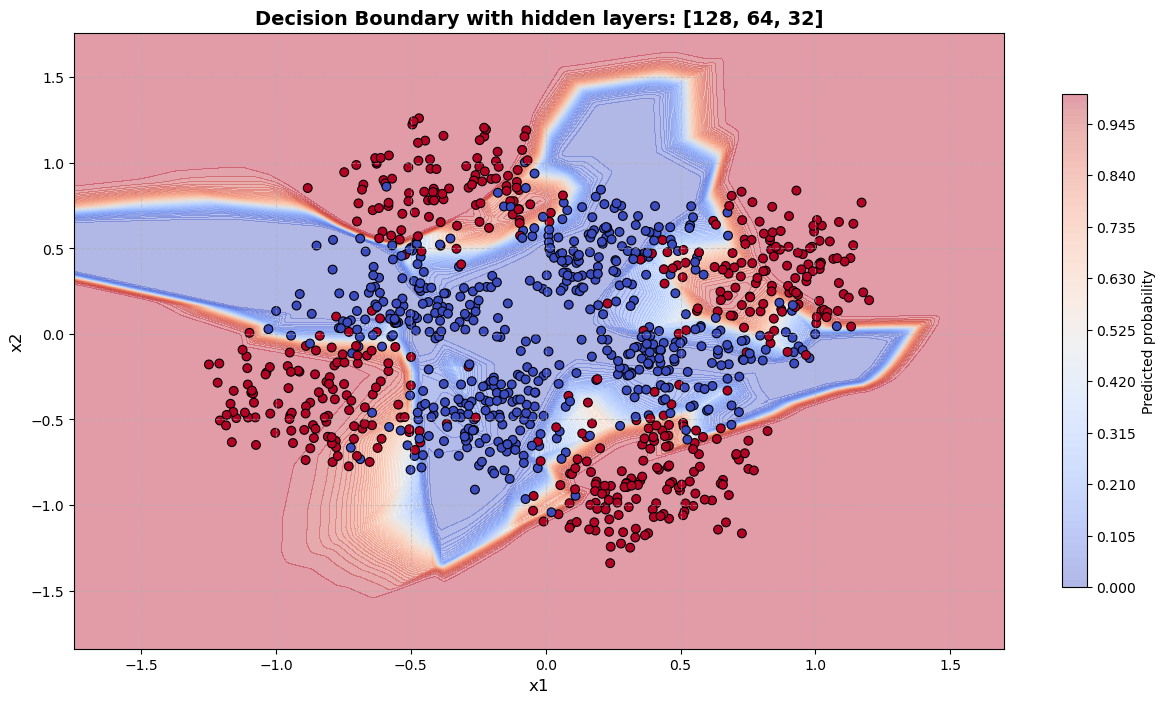

Accuracy of model1 on test set: 87.00%


In [11]:
# Lets change number of neurons in hidden layers
model4 = train_and_evaluate(hiddeln_layers=[128, 64, 32], learning_rate=0.01, n_epochs=1000)

Epoch [10/1000], Train Loss: 0.5237, Test Loss: 0.5303
Epoch [20/1000], Train Loss: 0.3456, Test Loss: 0.4436
Epoch [30/1000], Train Loss: 0.3322, Test Loss: 0.4153
Epoch [40/1000], Train Loss: 0.3120, Test Loss: 0.3792
Epoch [50/1000], Train Loss: 0.3034, Test Loss: 0.3666
Epoch [60/1000], Train Loss: 0.2969, Test Loss: 0.3592
Epoch [70/1000], Train Loss: 0.2882, Test Loss: 0.3456
Epoch [80/1000], Train Loss: 0.2777, Test Loss: 0.3297
Epoch [90/1000], Train Loss: 0.2671, Test Loss: 0.3211
Epoch [100/1000], Train Loss: 0.2567, Test Loss: 0.3074
Epoch [110/1000], Train Loss: 0.2483, Test Loss: 0.3070
Epoch [120/1000], Train Loss: 0.2425, Test Loss: 0.2989
Epoch [130/1000], Train Loss: 0.2395, Test Loss: 0.3078
Epoch [140/1000], Train Loss: 0.2376, Test Loss: 0.3012
Epoch [150/1000], Train Loss: 0.2361, Test Loss: 0.3114
Epoch [160/1000], Train Loss: 0.2345, Test Loss: 0.3033
Epoch [170/1000], Train Loss: 0.2329, Test Loss: 0.3064
Epoch [180/1000], Train Loss: 0.2325, Test Loss: 0.3076
E

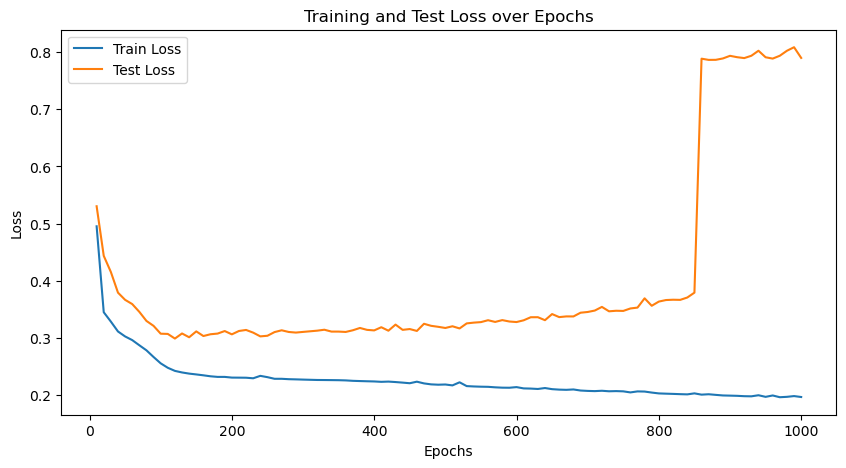

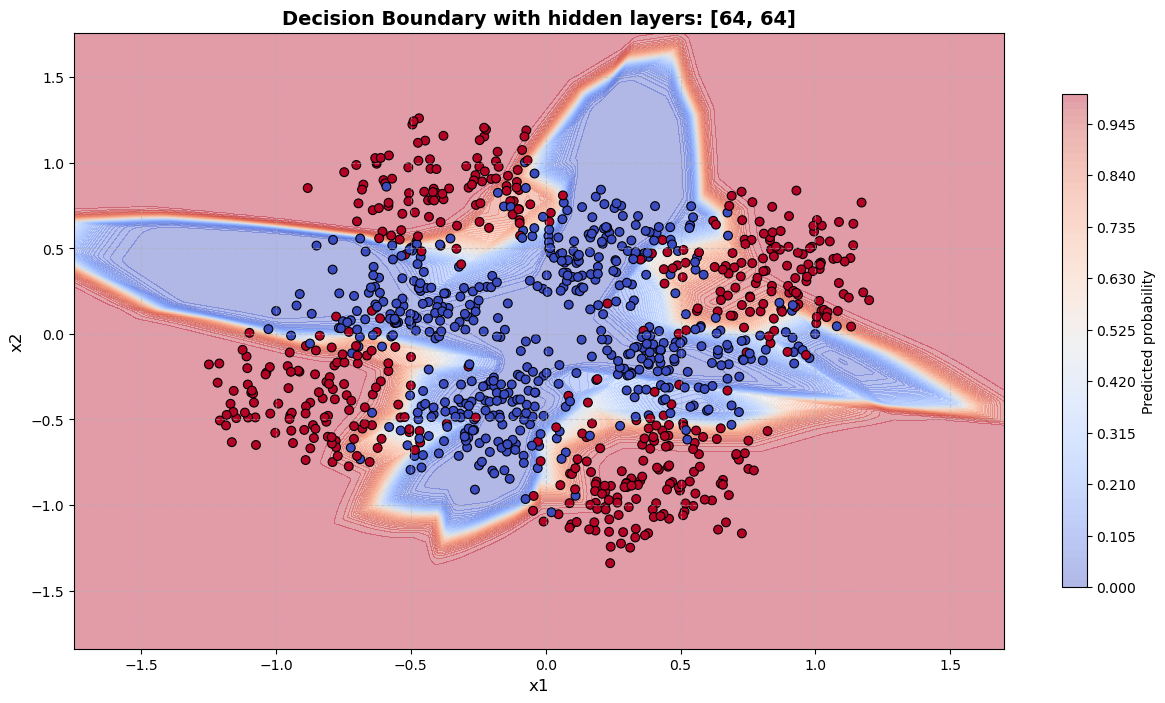

Accuracy of model1 on test set: 89.00%


In [12]:
# I will try another approach with more neurons when I have two layers 
model5 = train_and_evaluate(hiddeln_layers=[64, 64], learning_rate=0.01, n_epochs=1000)

Epoch [10/1000], Train Loss: 0.6931, Test Loss: 0.6928
Epoch [20/1000], Train Loss: 0.6865, Test Loss: 0.6871
Epoch [30/1000], Train Loss: 0.6753, Test Loss: 0.6772
Epoch [40/1000], Train Loss: 0.6562, Test Loss: 0.6611
Epoch [50/1000], Train Loss: 0.6248, Test Loss: 0.6349
Epoch [60/1000], Train Loss: 0.5773, Test Loss: 0.5955
Epoch [70/1000], Train Loss: 0.5175, Test Loss: 0.5458
Epoch [80/1000], Train Loss: 0.4540, Test Loss: 0.4927
Epoch [90/1000], Train Loss: 0.3996, Test Loss: 0.4492
Epoch [100/1000], Train Loss: 0.3630, Test Loss: 0.4223
Epoch [110/1000], Train Loss: 0.3432, Test Loss: 0.4108
Epoch [120/1000], Train Loss: 0.3330, Test Loss: 0.4056
Epoch [130/1000], Train Loss: 0.3269, Test Loss: 0.4015
Epoch [140/1000], Train Loss: 0.3223, Test Loss: 0.3967
Epoch [150/1000], Train Loss: 0.3186, Test Loss: 0.3920
Epoch [160/1000], Train Loss: 0.3156, Test Loss: 0.3876
Epoch [170/1000], Train Loss: 0.3127, Test Loss: 0.3834
Epoch [180/1000], Train Loss: 0.3100, Test Loss: 0.3796
E

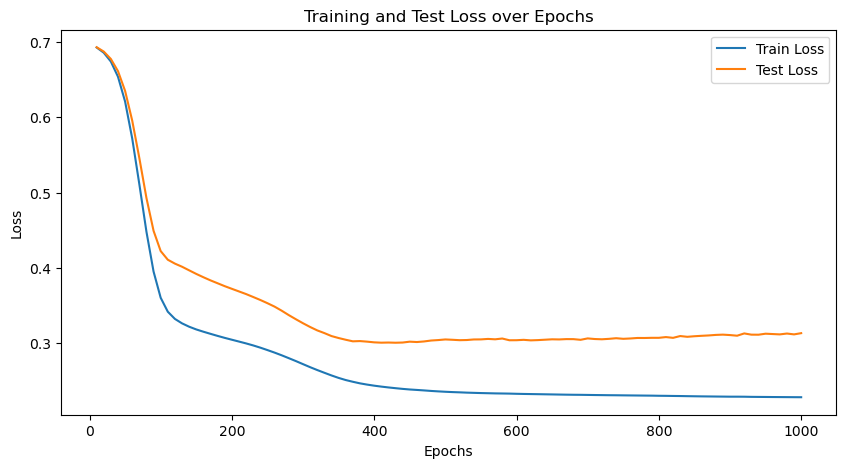

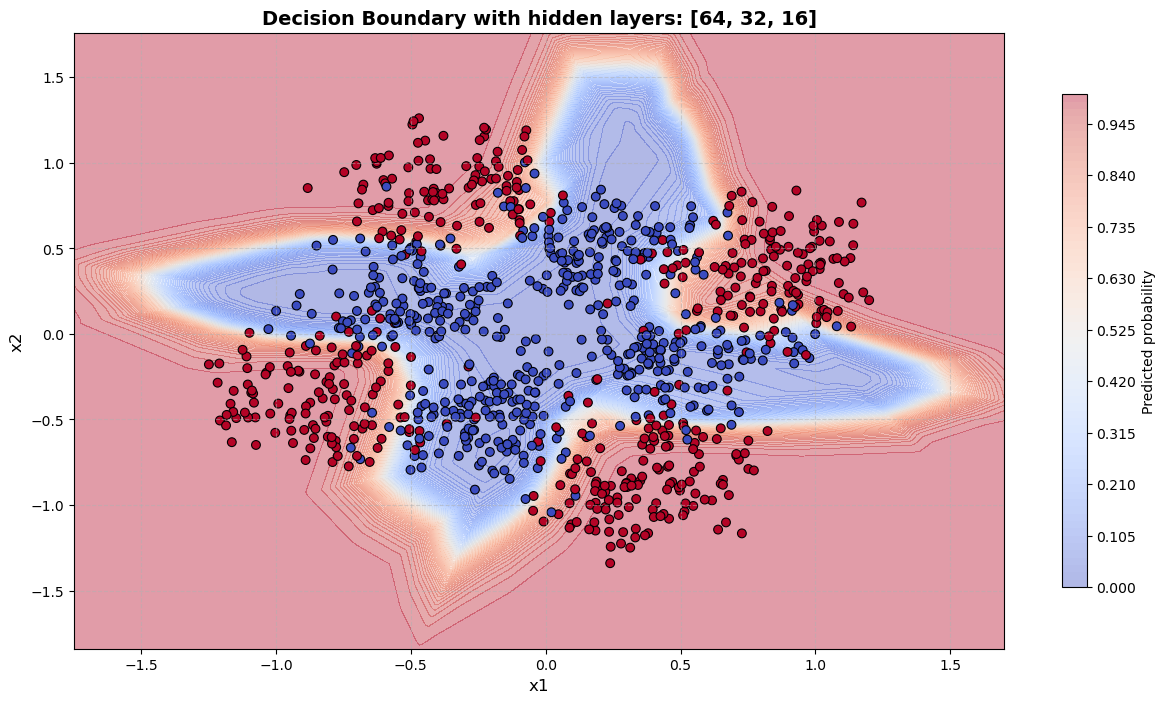

Accuracy of model1 on test set: 87.00%


In [13]:
# Now lets try to change learning rate to see how it will affect our training
model6 = train_and_evaluate(hiddeln_layers=[64, 32, 16], learning_rate=0.001, n_epochs=1000)

Epoch [10/1000], Train Loss: 0.6676, Test Loss: 0.6675
Epoch [20/1000], Train Loss: 0.6373, Test Loss: 0.6406
Epoch [30/1000], Train Loss: 0.5983, Test Loss: 0.6076
Epoch [40/1000], Train Loss: 0.5512, Test Loss: 0.5678
Epoch [50/1000], Train Loss: 0.4995, Test Loss: 0.5251
Epoch [60/1000], Train Loss: 0.4500, Test Loss: 0.4851
Epoch [70/1000], Train Loss: 0.4092, Test Loss: 0.4531
Epoch [80/1000], Train Loss: 0.3801, Test Loss: 0.4326
Epoch [90/1000], Train Loss: 0.3609, Test Loss: 0.4216
Epoch [100/1000], Train Loss: 0.3487, Test Loss: 0.4171
Epoch [110/1000], Train Loss: 0.3408, Test Loss: 0.4150
Epoch [120/1000], Train Loss: 0.3353, Test Loss: 0.4127
Epoch [130/1000], Train Loss: 0.3313, Test Loss: 0.4100
Epoch [140/1000], Train Loss: 0.3280, Test Loss: 0.4070
Epoch [150/1000], Train Loss: 0.3253, Test Loss: 0.4037
Epoch [160/1000], Train Loss: 0.3229, Test Loss: 0.4008
Epoch [170/1000], Train Loss: 0.3207, Test Loss: 0.3980
Epoch [180/1000], Train Loss: 0.3188, Test Loss: 0.3954
E

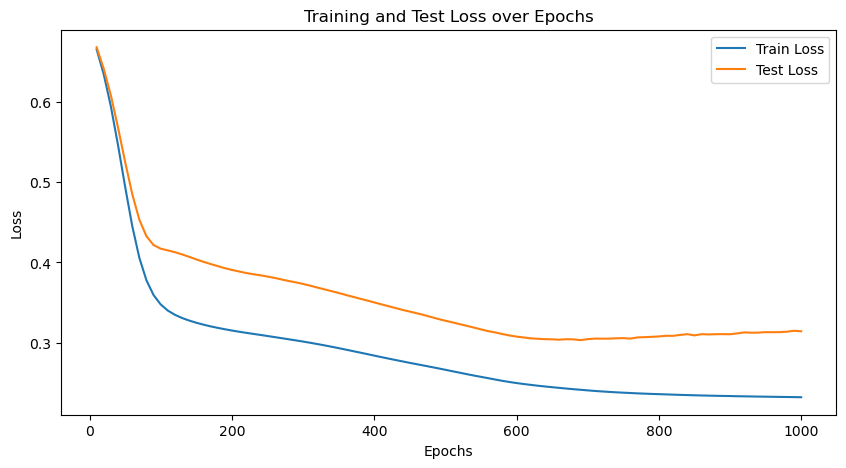

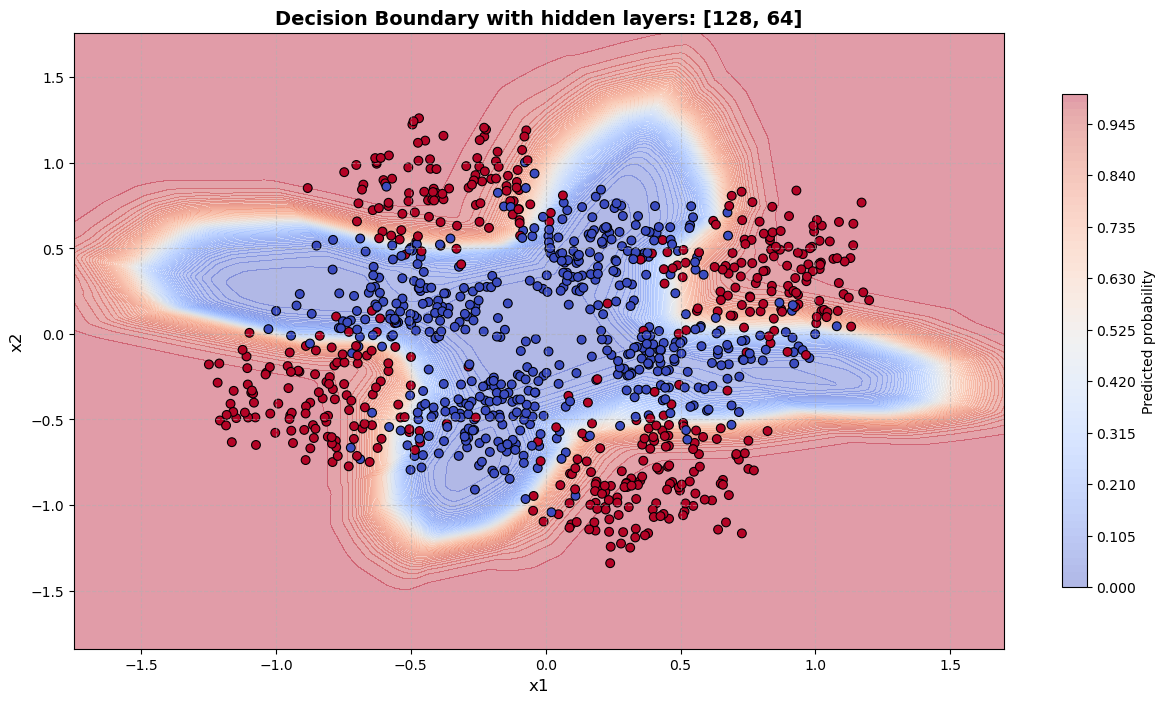

Accuracy of model1 on test set: 87.50%


In [14]:
# Another structure with this learning rate
model7 = train_and_evaluate(hiddeln_layers=[128, 64], learning_rate=0.001, n_epochs=1000)

In [15]:
# I have intuition that there is no sense to continue because my decision boundaries are good about for all the models 
# So I will stop here
# In my oppinion there is no any sense to change activation function 
# My intuition says that the main problem that we cant have higher accuracy than 88% is that our dataset has some merged parts
# So how hard we try we can't reach general solution that will give us accuracy more than 88%
# I will try to count which part of data is misclassified and see if there is some pattern

In [ ]:
# I want to create one function that will return misclassified points

def get_misclassified(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        preds = (model(X_tensor) >= 0.5).float()
    
    # Boolean mask of misclassifications
    mis_mask = preds.squeeze() != y_tensor.squeeze()
    
    # Extract misclassified points
    X_mis = X_tensor[mis_mask].cpu().numpy()
    y_true_mis = y_tensor[mis_mask].cpu().numpy()
    y_pred_mis = preds[mis_mask].cpu().numpy()
    
    return X_mis, y_true_mis, y_pred_mis

def plot_misclassified(model, X, y):
    # Get misclassified samples
    X_mis, y_true_mis, y_pred_mis = get_misclassified(model, X, y)

    plt.figure(figsize=(6,6))
    
    # Plot all data
    plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=10, alpha=0.4, label='Correct')

    # Plot misclassified points
    plt.scatter(X_mis[:,0], X_mis[:,1], 
                edgecolor='black', 
                facecolor='yellow',
                s=60,
                label='Misclassified')
    
    plt.legend()
    plt.gca().set_aspect('equal', 'box')
    plt.title("Misclassified Points")
    plt.show()

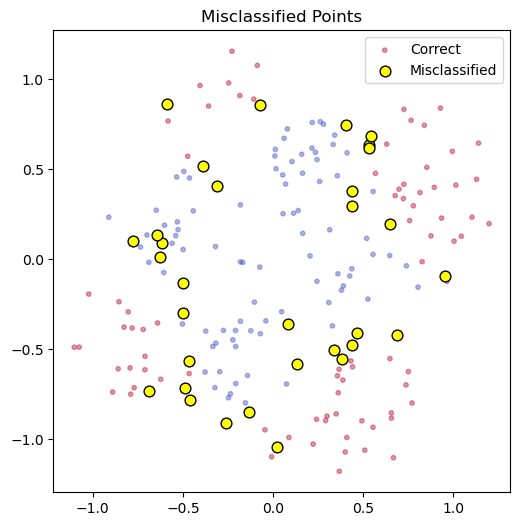

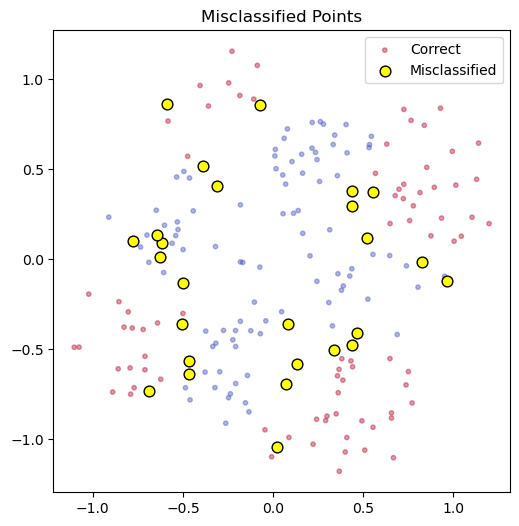

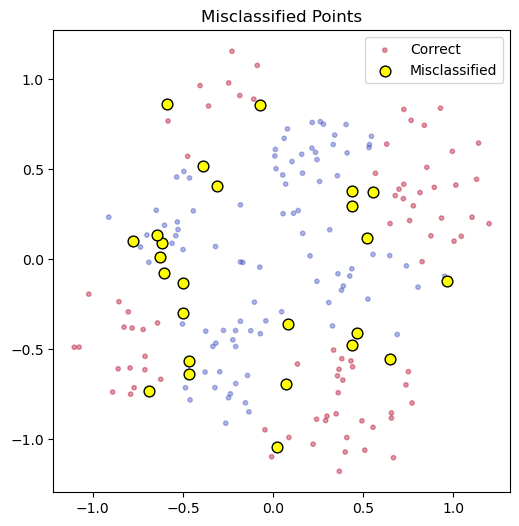

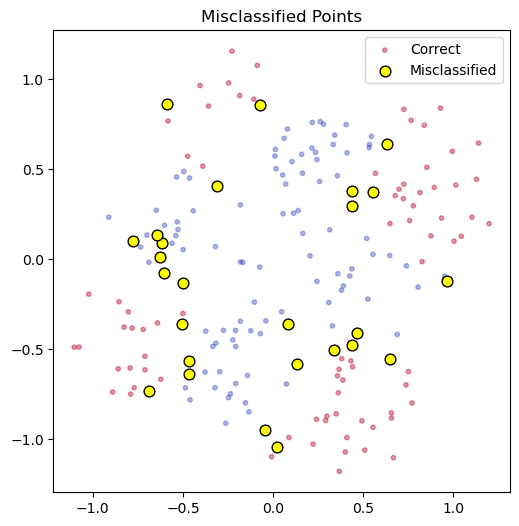

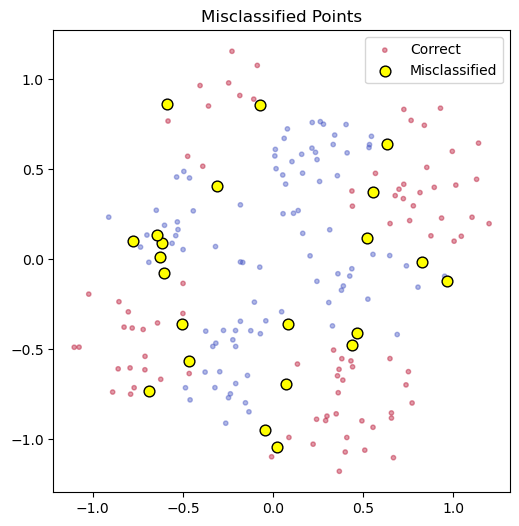

In [22]:
# Lets see the misclassified points 
plot_misclassified(model1, X_test_tensor, y_test_tensor)
plot_misclassified(model2, X_test_tensor, y_test_tensor)
plot_misclassified(model3, X_test_tensor, y_test_tensor)
plot_misclassified(model4, X_test_tensor, y_test_tensor)
plot_misclassified(model5, X_test_tensor, y_test_tensor)


### Conclusion ###
#### We can see from our dataset that our models have catched the general patterns, and the main reason for our ~87% accuracy is misclassification parth caoused by our noise in our dataset ####